In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns1 = inspector.get_columns("measurement")
for c in columns1:
    print(c['name'], c['type'])

columns2 = inspector.get_columns("station")
for c in columns2:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


Last date: 2017-08-23
A year ago date: 2016-08-23


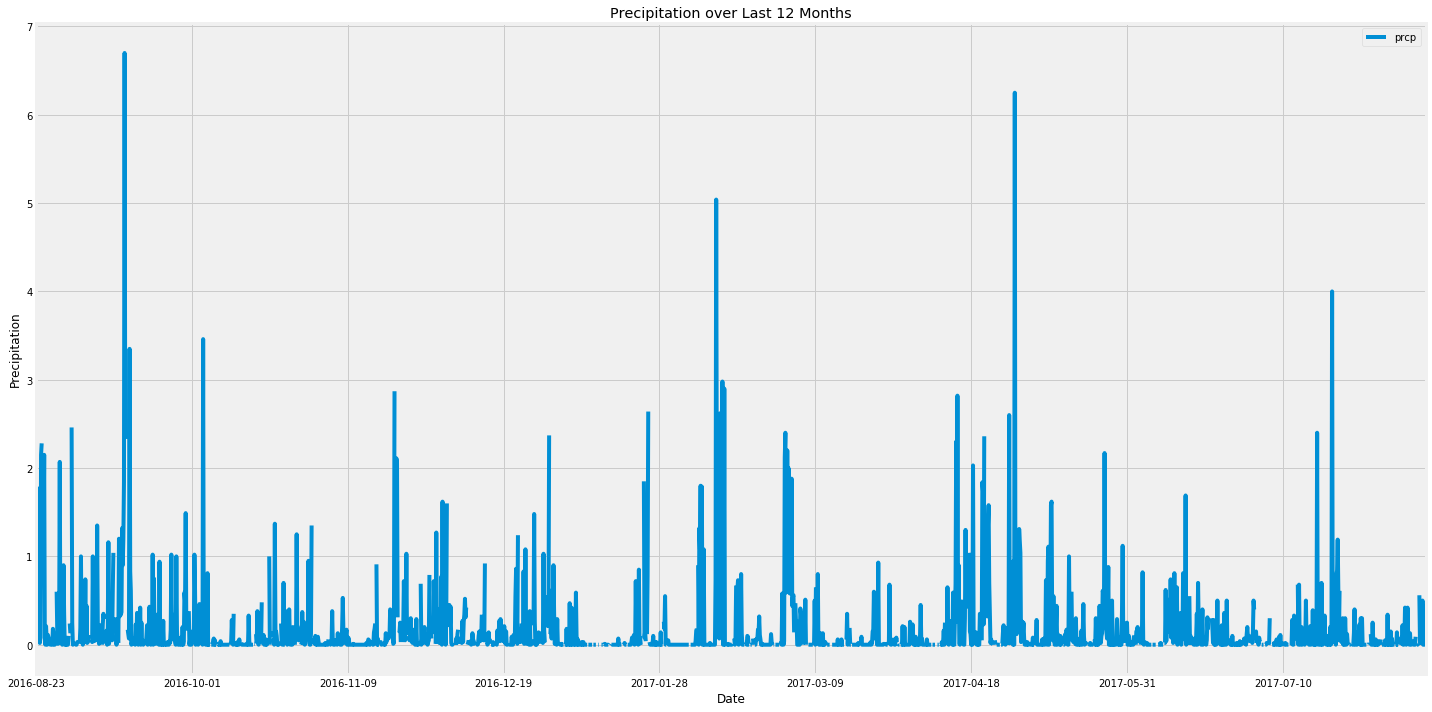

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).first()[0]
last_date_updated = dt.datetime.strptime(last_date,'%Y-%m-%d')
year_ago = dt.date(year=last_date_updated.year-1, month=last_date_updated.month, day=last_date_updated.day)
print(f"Last date: {last_date}")
print(f"A year ago date: {year_ago}")

# Perform a query to retrieve the data and precipitation scores
prcp_year_results = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_results = pd.DataFrame(prcp_year_results)
prcp_results_df = prcp_results.set_index('date').sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_results_df.plot(kind = 'line', figsize = (20,10))
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation over Last 12 Months')
plt.tight_layout()

In [12]:
prcp_year_results

prcp_data = {}
for data in prcp_year_results:
    prcp_data[data[0]] = data[1]
prcp_data

{'2016-08-23': 0.7,
 '2016-08-24': 1.45,
 '2016-08-25': 0.11,
 '2016-08-26': 0.01,
 '2016-08-27': None,
 '2016-08-28': 2.07,
 '2016-08-29': 0.9,
 '2016-08-30': 0.05,
 '2016-08-31': 2.46,
 '2016-09-01': 0.01,
 '2016-09-02': 0.03,
 '2016-09-03': 1.0,
 '2016-09-04': 0.44,
 '2016-09-05': 0.18,
 '2016-09-06': 1.0,
 '2016-09-07': 1.35,
 '2016-09-08': 0.15,
 '2016-09-09': 0.35,
 '2016-09-10': 1.16,
 '2016-09-11': 0.6,
 '2016-09-12': 1.04,
 '2016-09-13': 1.2,
 '2016-09-14': 6.7,
 '2016-09-15': 3.35,
 '2016-09-16': 0.61,
 '2016-09-17': 0.23,
 '2016-09-18': 0.42,
 '2016-09-19': 0.25,
 '2016-09-20': 0.43,
 '2016-09-21': 1.02,
 '2016-09-22': 0.75,
 '2016-09-23': 0.33,
 '2016-09-24': 0.27,
 '2016-09-25': 0.04,
 '2016-09-26': 1.02,
 '2016-09-27': 1.0,
 '2016-09-28': 0.05,
 '2016-09-29': 1.49,
 '2016-09-30': 0.38,
 '2016-10-01': 1.02,
 '2016-10-02': 0.61,
 '2016-10-03': 0.46,
 '2016-10-04': 3.46,
 '2016-10-05': 0.81,
 '2016-10-06': 0.04,
 '2016-10-07': 0.01,
 '2016-10-08': 0.04,
 '2016-10-09': 0.0,
 

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_results_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [30]:
# Design a query to show how many stations are available in this dataset?
stations_list = session.query(Measurement.station).distinct().all()
print(stations_list)
print(f"There are total {len(stations_list)} stations available")

[('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)]
There are total 9 stations available


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.id)).\
        group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
print(results)
station_id = results[0][0]
print(f"The station {station_id} is the most active station.")

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
The station USC00519281 is the most active station.


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_result = session.query(Measurement.station,func.max(Measurement.tobs),
                               func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == station_id).all()
station_result
min_temp = station_result[0][2]
max_temp = station_result[0][1]
avg_temp = station_result[0][3]

print(f"The recorded temperature for station {station_id} is as follow: \n"
      f"Lowest temperature: {min_temp}\n"
      f"Highest temperature: {max_temp}\n"
      f"Average temperature: {avg_temp}")

The recorded temperature for station USC00519281 is as follow: 
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


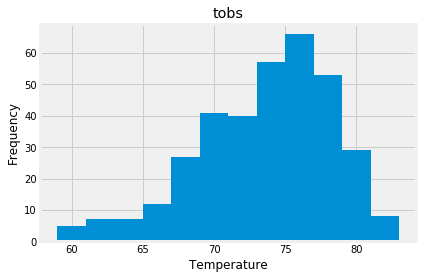

In [17]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_year_results = session.query(Measurement.station,Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == station_id).\
                    filter(Measurement.date >= year_ago).all()
tobs_df = pd.DataFrame(tobs_year_results)
tobs_df.hist('tobs', bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

# Temperature Analysis I

In [18]:
from scipy import stats

june_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).group_by(Measurement.station).\
            filter(func.strftime("%m", Measurement.date) == "06").all()

dec_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).group_by(Measurement.station).\
                          filter(func.strftime("%m", Measurement.date) == "12").all()

In [19]:
june_data = [data[1] for data in june_temp]
dec_data = [data[1] for data in dec_temp]

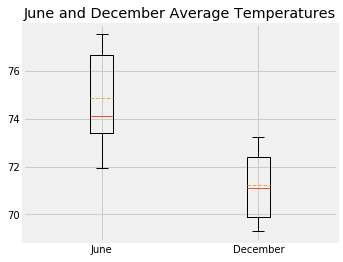

In [20]:
data = [june_data, dec_data]
plt.figure(figsize = (5,4))
red_diamond = dict(markerfacecolor='r', marker='D', markersize = 11)
plt.boxplot(data, showmeans = True, meanline = True, flierprops = red_diamond, labels = ["June","December"])
plt.title("June and December Average Temperatures")

plt.show()

In [21]:
stats.ttest_ind(june_data, dec_data)

Ttest_indResult(statistic=4.615865424404701, pvalue=0.00028626292761018595)

# Temperature Analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = "2016-12-05"
end_date = "2016-12-18"
temp_results = calc_temps(start_date, end_date)
print(temp_results)


[(60.0, 69.7, 78.0)]


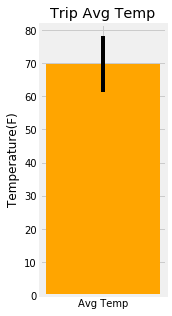

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize = (2,5))
plt.bar(x = "Avg Temp", height = temp_results[0][1], width = 0.5, color = "orange", 
        yerr = temp_results[0][2]-temp_results[0][1])
plt.title("Trip Avg Temp")
plt.ylabel("Temperature(F)")
plt.show()

# Daily Rainfall Average

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_data = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, 
                              Station.latitude, Station.longitude, Station.elevation).\
                filter(Measurement.station == Station.station).\
                filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
print(rainfall_data)


[('USC00516128', 2.6999999999999997, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00519523', 1.2200000000000002, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00519397', 1.3200000000000003, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00513117', 1.5300000000000005, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519281', 2.1000000000000005, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00514830', 1.05, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00517948', 0.29000000000000004, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2018-12-05"
end_date = "2018-12-18"
# Use the start and end date to create a range of dates
date_range = []
start = dt.datetime.strptime(start_date, '%Y-%m-%d')
end = dt.datetime.strptime(end_date, '%Y-%m-%d')
step = dt.timedelta(days=1)
while start <= end:
    date_range.append(start.date())
    start += step
# Stip off the year and save a list of %m-%d strings
date_list = [date.strftime("%m-%d") for date in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in date_list]
normals

[[(64.0, 70.92156862745098, 78.0)],
 [(61.0, 69.3921568627451, 78.0)],
 [(58.0, 69.2, 79.0)],
 [(60.0, 70.27450980392157, 83.0)],
 [(64.0, 71.90196078431373, 80.0)],
 [(61.0, 71.24528301886792, 78.0)],
 [(64.0, 72.38775510204081, 78.0)],
 [(64.0, 70.88235294117646, 79.0)],
 [(65.0, 70.9423076923077, 80.0)],
 [(65.0, 71.18, 78.0)],
 [(62.0, 71.34, 79.0)],
 [(60.0, 69.62264150943396, 82.0)],
 [(63.0, 70.64, 77.0)],
 [(63.0, 71.28, 77.0)]]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

min_temp = [data[0][0] for data in normals]
avg_temp = [data[0][1] for data in normals]
max_temp = [data[0][2] for data in normals]
trip_dates = [date.strftime("%y-%m-%d") for date in date_range]

normals_df = pd.DataFrame({"date":trip_dates, "min_temp":min_temp, "max_temp":max_temp, "avg_temp":avg_temp})

normals_df_update = normals_df.set_index("date")
normals_df_update

,min_temp,max_temp,avg_temp
date,,,
18-12-05,64.0,78.0,70.921569
18-12-06,61.0,78.0,69.392157
18-12-07,58.0,79.0,69.200000
18-12-08,60.0,83.0,70.274510
18-12-09,64.0,80.0,71.901961
18-12-10,61.0,78.0,71.245283
18-12-11,64.0,78.0,72.387755
18-12-12,64.0,79.0,70.882353
18-12-13,65.0,80.0,70.942308


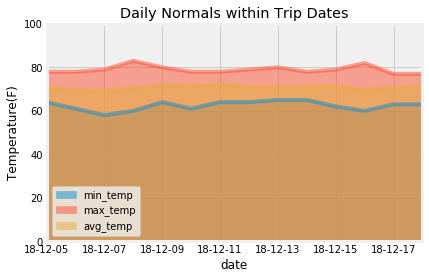

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df_update.plot.area(stacked=False, yticks = (0,20,40,60,80,100))
plt.ylabel("Temperature(F)")
plt.title("Daily Normals within Trip Dates")
plt.show()